In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import re
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameter

In [3]:
CFG = {
    'EPOCHS': 20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

## Randomseed를 fix

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Train, Validation fix

In [5]:
df = pd.read_csv('./train.csv')

In [6]:
df.head()

,img_path,upscale_img_path,label
0,./train/TRAIN_00000.jpg,./upscale_train/TRAIN_00000.png,Ruddy Shelduck
1,./train/TRAIN_00001.jpg,./upscale_train/TRAIN_00001.png,Gray Wagtail
2,./train/TRAIN_00002.jpg,./upscale_train/TRAIN_00002.png,Indian Peacock
3,./train/TRAIN_00003.jpg,./upscale_train/TRAIN_00003.png,Common Kingfisher
4,./train/TRAIN_00004.jpg,./upscale_train/TRAIN_00004.png,Common Kingfisher


In [7]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [8]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

## CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

## 평균과 표준편차 계산

In [10]:
import cv2
import numpy as np
from tqdm import tqdm  # 진행 상황 표시

'''def calculate_mean_std_from_dataframe(df, img_column):
    """
    데이터프레임에서 이미지 경로를 읽어 RGB 채널별 평균과 표준편차를 계산하는 함수
    """
    mean = np.zeros(3)  # R, G, B 채널별 평균
    std = np.zeros(3)   # R, G, B 채널별 표준편차
    total_pixels = 0

    for img_path in tqdm(df[img_column]):
        # 이미지 불러오기
        image = cv2.imread(img_path)  # BGR로 불러옴
        if image is None:
            print(f"이미지를 불러올 수 없습니다: {img_path}")
            continue
        
        # BGR -> RGB 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = image / 255.0  # [0, 1] 범위로 스케일링

        # H x W 차원에 대해 평균과 표준편차 계산
        mean += image.mean(axis=(0, 1))  # 채널별 평균 계산
        std += image.std(axis=(0, 1))   # 채널별 표준편차 계산
        total_pixels += 1

    # 총 이미지 개수로 나누어 최종 평균 및 표준편차 계산
    mean /= total_pixels
    std /= total_pixels

    return mean, std

# 'train' 데이터프레임에서 'img_path' 열을 사용
mean, std = calculate_mean_std_from_dataframe(train, 'img_path')

print(f"Mean (RGB): {mean}")
print(f"Std (RGB): {std}")'''

'def calculate_mean_std_from_dataframe(df, img_column):\n    """\n    데이터프레임에서 이미지 경로를 읽어 RGB 채널별 평균과 표준편차를 계산하는 함수\n    """\n    mean = np.zeros(3)  # R, G, B 채널별 평균\n    std = np.zeros(3)   # R, G, B 채널별 표준편차\n    total_pixels = 0\n\n    for img_path in tqdm(df[img_column]):\n        # 이미지 불러오기\n        image = cv2.imread(img_path)  # BGR로 불러옴\n        if image is None:\n            print(f"이미지를 불러올 수 없습니다: {img_path}")\n            continue\n        \n        # BGR -> RGB 변환\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환\n        image = image / 255.0  # [0, 1] 범위로 스케일링\n\n        # H x W 차원에 대해 평균과 표준편차 계산\n        mean += image.mean(axis=(0, 1))  # 채널별 평균 계산\n        std += image.std(axis=(0, 1))   # 채널별 표준편차 계산\n        total_pixels += 1\n\n    # 총 이미지 개수로 나누어 최종 평균 및 표준편차 계산\n    mean /= total_pixels\n    std /= total_pixels\n\n    return mean, std\n\n# \'train\' 데이터프레임에서 \'img_path\' 열을 사용\nmean, std = calculate_mean_std_from_dataframe(train, \'img_path\')\n

In [11]:
train_transform = A.Compose([
    A.Normalize(mean=(0.510, 0.519, 0.435), std=(0.163, 0.162, 0.172)),
    ToTensorV2()
])


test_transform = A.Compose([
    A.Normalize(mean=(0.510, 0.519, 0.435), std=(0.163, 0.162, 0.172)),
    ToTensorV2()
])

In [12]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model define (ResNet 34)

### Residual Block Define

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

In [14]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(ResidualBlock, 64, 3)
        self.layer2 = self._make_layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Dropout 추가
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # 50% 확률로 드롭
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [15]:
num_classes = 25  # 데이터셋 클래스 수
model = ResNet34(num_classes=num_classes).to(device)

## 손실 함수 및 옵티마이저 정의

In [16]:
criterion = nn.CrossEntropyLoss()  # 분류 문제에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

## 학습 및 검증 루프 정의

In [17]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_accuracies = []  # Train accuracy 기록
    val_accuracies = []    # Validation accuracy 기록
    best_val_acc = 0.0     # 최고 검증 정확도를 저장

    for epoch in range(epochs):
        # Train Phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        train_accuracies.append(train_acc)  # Train accuracy 저장
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}"):
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)

                # Validation metrics
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)  # Validation accuracy 저장
        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved with Val Acc: {best_val_acc:.4f}")
    
    return train_accuracies, val_accuracies

## 테스트 정의

In [18]:
def test_model(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")

## Test data 선언

In [19]:
test = pd.read_csv('./test.csv')

In [20]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [21]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

## Run

In [22]:
train_accuracies, val_accuracies = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=CFG['EPOCHS']
)

Training Epoch 1/20: 100% 347/347 [00:19<00:00, 17.52it/s]


Epoch [1/20], Train Loss: 3.1547, Train Acc: 0.1184


Validating Epoch 1/20: 100% 149/149 [00:05<00:00, 24.89it/s]


Epoch [1/20], Val Loss: 2.7486, Val Acc: 0.2010
Best model saved with Val Acc: 0.2010


Training Epoch 2/20: 100% 347/347 [00:18<00:00, 19.05it/s]


Epoch [2/20], Train Loss: 2.5827, Train Acc: 0.2519


Validating Epoch 2/20: 100% 149/149 [00:05<00:00, 26.54it/s]


Epoch [2/20], Val Loss: 2.3584, Val Acc: 0.3103
Best model saved with Val Acc: 0.3103


Training Epoch 3/20: 100% 347/347 [00:17<00:00, 19.47it/s]


Epoch [3/20], Train Loss: 2.2139, Train Acc: 0.3509


Validating Epoch 3/20: 100% 149/149 [00:05<00:00, 25.79it/s]


Epoch [3/20], Val Loss: 2.3466, Val Acc: 0.3267
Best model saved with Val Acc: 0.3267


Training Epoch 4/20: 100% 347/347 [00:18<00:00, 19.03it/s]


Epoch [4/20], Train Loss: 1.9262, Train Acc: 0.4316


Validating Epoch 4/20: 100% 149/149 [00:05<00:00, 27.11it/s]


Epoch [4/20], Val Loss: 2.5553, Val Acc: 0.3679
Best model saved with Val Acc: 0.3679


Training Epoch 5/20: 100% 347/347 [00:18<00:00, 19.04it/s]


Epoch [5/20], Train Loss: 1.6781, Train Acc: 0.5064


Validating Epoch 5/20: 100% 149/149 [00:05<00:00, 26.37it/s]


Epoch [5/20], Val Loss: 1.9022, Val Acc: 0.4624
Best model saved with Val Acc: 0.4624


Training Epoch 6/20: 100% 347/347 [00:18<00:00, 18.71it/s]


Epoch [6/20], Train Loss: 1.4238, Train Acc: 0.5775


Validating Epoch 6/20: 100% 149/149 [00:05<00:00, 25.54it/s]


Epoch [6/20], Val Loss: 1.9147, Val Acc: 0.4690
Best model saved with Val Acc: 0.4690


Training Epoch 7/20: 100% 347/347 [00:18<00:00, 18.58it/s]


Epoch [7/20], Train Loss: 1.2386, Train Acc: 0.6245


Validating Epoch 7/20: 100% 149/149 [00:05<00:00, 26.17it/s]


Epoch [7/20], Val Loss: 1.9318, Val Acc: 0.4755
Best model saved with Val Acc: 0.4755


Training Epoch 8/20: 100% 347/347 [00:18<00:00, 18.57it/s]


Epoch [8/20], Train Loss: 1.0994, Train Acc: 0.6687


Validating Epoch 8/20: 100% 149/149 [00:05<00:00, 26.59it/s]


Epoch [8/20], Val Loss: 1.8981, Val Acc: 0.4953
Best model saved with Val Acc: 0.4953


Training Epoch 9/20: 100% 347/347 [00:18<00:00, 19.13it/s]


Epoch [9/20], Train Loss: 0.8338, Train Acc: 0.7487


Validating Epoch 9/20: 100% 149/149 [00:05<00:00, 26.46it/s]


Epoch [9/20], Val Loss: 2.1346, Val Acc: 0.4959
Best model saved with Val Acc: 0.4959


Training Epoch 10/20: 100% 347/347 [00:17<00:00, 19.31it/s]


Epoch [10/20], Train Loss: 0.7015, Train Acc: 0.7850


Validating Epoch 10/20: 100% 149/149 [00:05<00:00, 26.63it/s]


Epoch [10/20], Val Loss: 1.9353, Val Acc: 0.5285
Best model saved with Val Acc: 0.5285


Training Epoch 11/20: 100% 347/347 [00:18<00:00, 18.61it/s]


Epoch [11/20], Train Loss: 0.5680, Train Acc: 0.8278


Validating Epoch 11/20: 100% 149/149 [00:05<00:00, 25.56it/s]


Epoch [11/20], Val Loss: 2.3120, Val Acc: 0.4991


Training Epoch 12/20: 100% 347/347 [00:18<00:00, 18.87it/s]


Epoch [12/20], Train Loss: 0.4664, Train Acc: 0.8555


Validating Epoch 12/20: 100% 149/149 [00:05<00:00, 26.06it/s]


Epoch [12/20], Val Loss: 2.3391, Val Acc: 0.5226


Training Epoch 13/20: 100% 347/347 [00:18<00:00, 18.98it/s]


Epoch [13/20], Train Loss: 0.3776, Train Acc: 0.8809


Validating Epoch 13/20: 100% 149/149 [00:05<00:00, 25.71it/s]


Epoch [13/20], Val Loss: 2.3528, Val Acc: 0.5132


Training Epoch 14/20: 100% 347/347 [00:19<00:00, 17.99it/s]


Epoch [14/20], Train Loss: 0.3204, Train Acc: 0.8995


Validating Epoch 14/20: 100% 149/149 [00:05<00:00, 25.29it/s]


Epoch [14/20], Val Loss: 2.3284, Val Acc: 0.5340
Best model saved with Val Acc: 0.5340


Training Epoch 15/20: 100% 347/347 [00:19<00:00, 17.97it/s]


Epoch [15/20], Train Loss: 0.2744, Train Acc: 0.9114


Validating Epoch 15/20: 100% 149/149 [00:05<00:00, 25.87it/s]


Epoch [15/20], Val Loss: 2.5306, Val Acc: 0.5270


Training Epoch 16/20: 100% 347/347 [00:18<00:00, 18.84it/s]


Epoch [16/20], Train Loss: 0.2455, Train Acc: 0.9227


Validating Epoch 16/20: 100% 149/149 [00:05<00:00, 26.15it/s]


Epoch [16/20], Val Loss: 2.4185, Val Acc: 0.5445
Best model saved with Val Acc: 0.5445


Training Epoch 17/20: 100% 347/347 [00:18<00:00, 18.60it/s]


Epoch [17/20], Train Loss: 0.2168, Train Acc: 0.9324


Validating Epoch 17/20: 100% 149/149 [00:05<00:00, 25.82it/s]


Epoch [17/20], Val Loss: 2.4049, Val Acc: 0.5405


Training Epoch 18/20: 100% 347/347 [00:18<00:00, 18.64it/s]


Epoch [18/20], Train Loss: 0.2179, Train Acc: 0.9313


Validating Epoch 18/20: 100% 149/149 [00:05<00:00, 25.24it/s]


Epoch [18/20], Val Loss: 2.3767, Val Acc: 0.5504
Best model saved with Val Acc: 0.5504


Training Epoch 19/20: 100% 347/347 [00:18<00:00, 18.65it/s]


Epoch [19/20], Train Loss: 0.1901, Train Acc: 0.9428


Validating Epoch 19/20: 100% 149/149 [00:05<00:00, 25.27it/s]


Epoch [19/20], Val Loss: 2.6200, Val Acc: 0.5401


Training Epoch 20/20: 100% 347/347 [00:18<00:00, 18.61it/s]


Epoch [20/20], Train Loss: 0.1970, Train Acc: 0.9395


Validating Epoch 20/20: 100% 149/149 [00:06<00:00, 24.22it/s]


Epoch [20/20], Val Loss: 2.3945, Val Acc: 0.5542
Best model saved with Val Acc: 0.5542


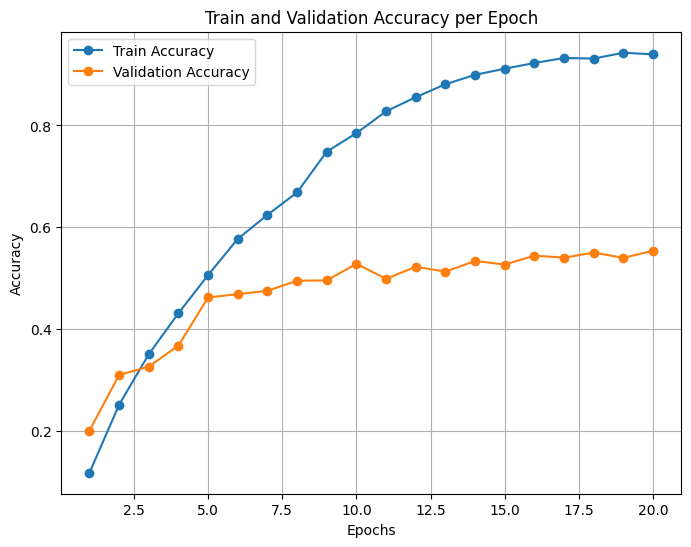

In [23]:
import matplotlib.pyplot as plt

def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# 정확도 그래프 그리기
plot_accuracies(train_accuracies, val_accuracies)

## Inference

In [24]:
test = pd.read_csv('./test.csv')

In [25]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [26]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [27]:
preds = inference(model, test_loader, device)

100% 213/213 [00:08<00:00, 26.60it/s]


## Submission

In [28]:
submit = pd.read_csv('./sample_submission.csv')

In [29]:
submit.head()

,id,label
0,TEST_00000,Indian Roller
1,TEST_00001,Indian Roller
2,TEST_00002,Indian Roller
3,TEST_00003,Indian Roller
4,TEST_00004,Indian Roller


In [30]:
submit['label'] = preds

In [31]:
submit.head()

,id,label
0,TEST_00000,Coppersmith Barbet
1,TEST_00001,Asian Green Bee-Eater
2,TEST_00002,Common Rosefinch
3,TEST_00003,Red-Wattled Lapwing
4,TEST_00004,White Wagtail


In [32]:
submit.to_csv('./baseline_submit.csv', index=False)

ResNet-34로 다양한 시도를 해봤지만... 계속해서 오버피팅 현상이 나타났습니다 :(